# Create Plots of Detected Signals
Given a star name, the spectrum's index in the list of total spectra, and a file location containing the table of results for that spectrum, plot up all the detected signals in that spectrum and save it into that folder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
import astropy.io.fits as fits
import ast
from scipy.interpolate import splev, splrep
from mpmath import mp

In [13]:
star_name = 'HIP25278'
spectrum_index = 243
file_location = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/MyStuff/LaserDetectionResults/SNRBinningResults/LaserDetectionResults1/243_HIP25278'

In [14]:
SNR_vals = np.load('/mnt_home/zoek/code/APF-BL-DAP/Zoe/SNR.npy')
SNR = SNR_vals[spectrum_index]
print(SNR)

161.6475590297154


In [15]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians by adding a gaussian into a given location in the spectrum
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect

# same as above, but REMOVES the part of the data where the gaussian is inserted
def insert_gaussian_with_data_removal(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)


plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams.update({'font.size': 30})
# plt.rcParams["figure.figsize"] = (9,6)
# plt.rcParams.update({'font.size': 15})

## Read in the reduced data from Anna Zuckerman's repo

In [16]:
directory = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDR_corrected_wl_scale'

# every file in Anna's NDR_corrected_wl_scale folder
list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        list_of_files = np.append(list_of_files, file_path)

In [17]:
# Choose the specific spectrum in Anna's folder.
f = list_of_files[spectrum_index]
file = fits.open(f)
flux = file[0].data
wl = file[1].data

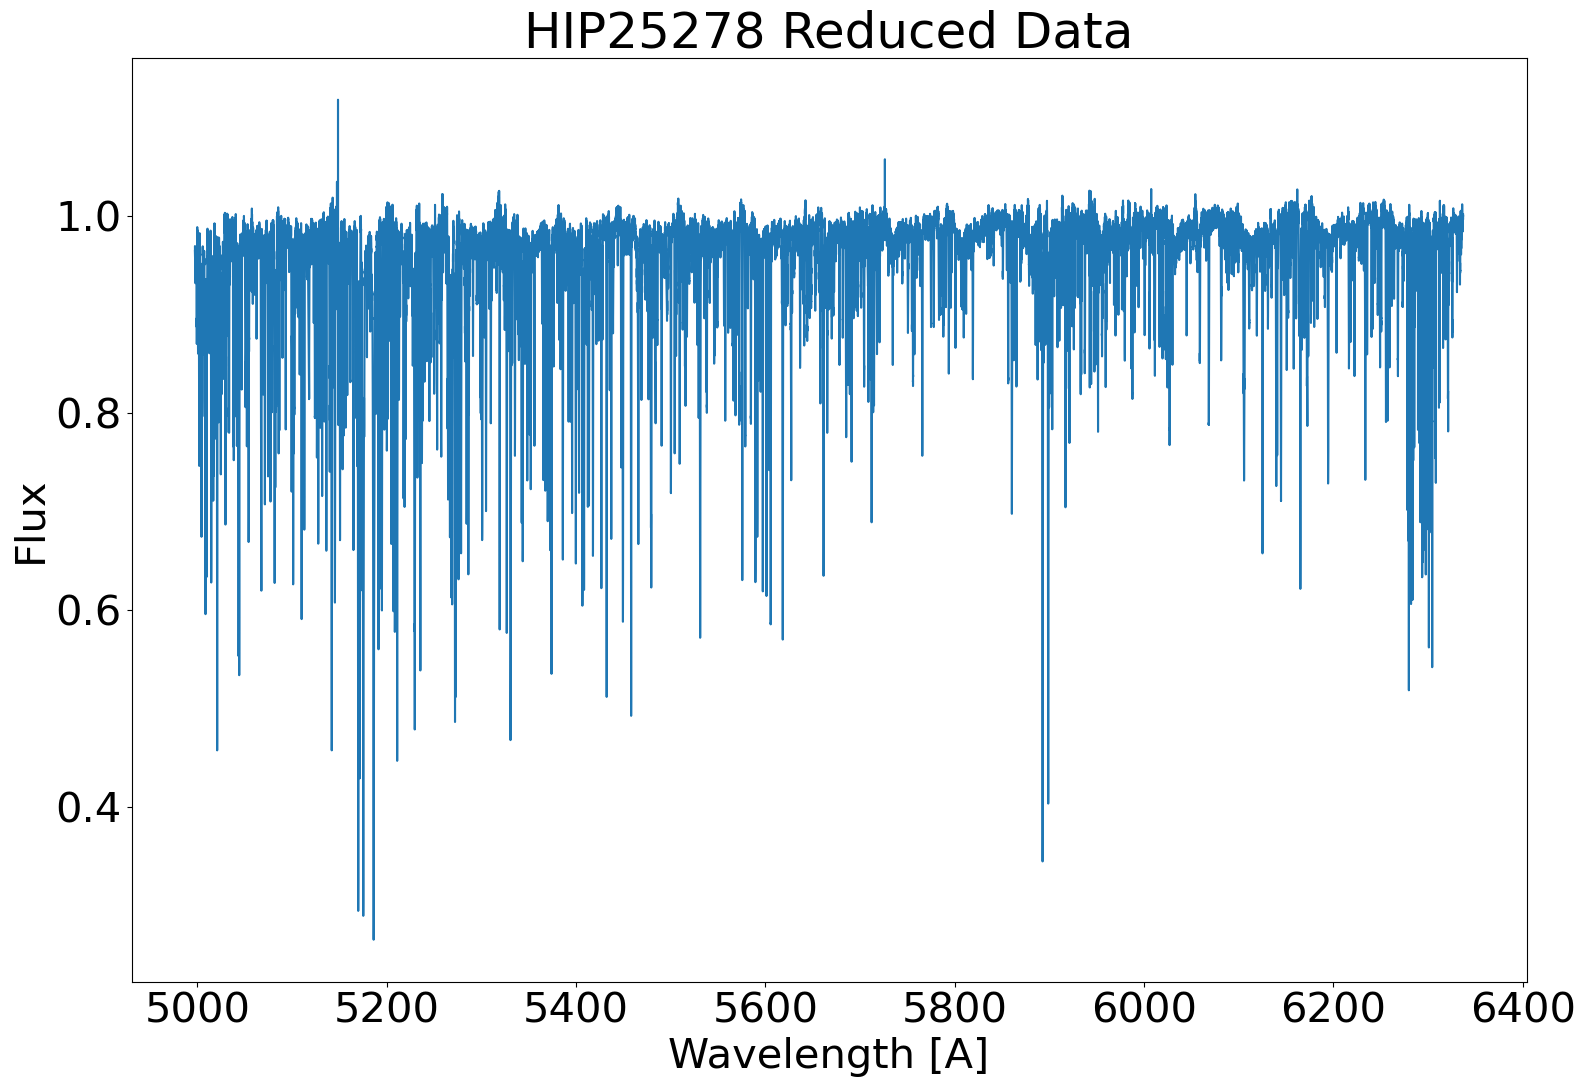

In [18]:
plt.plot(wl, flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title(star_name + ' Reduced Data')
plt.show()

## Create Plots of Detections

m is: 1.0017330008989798


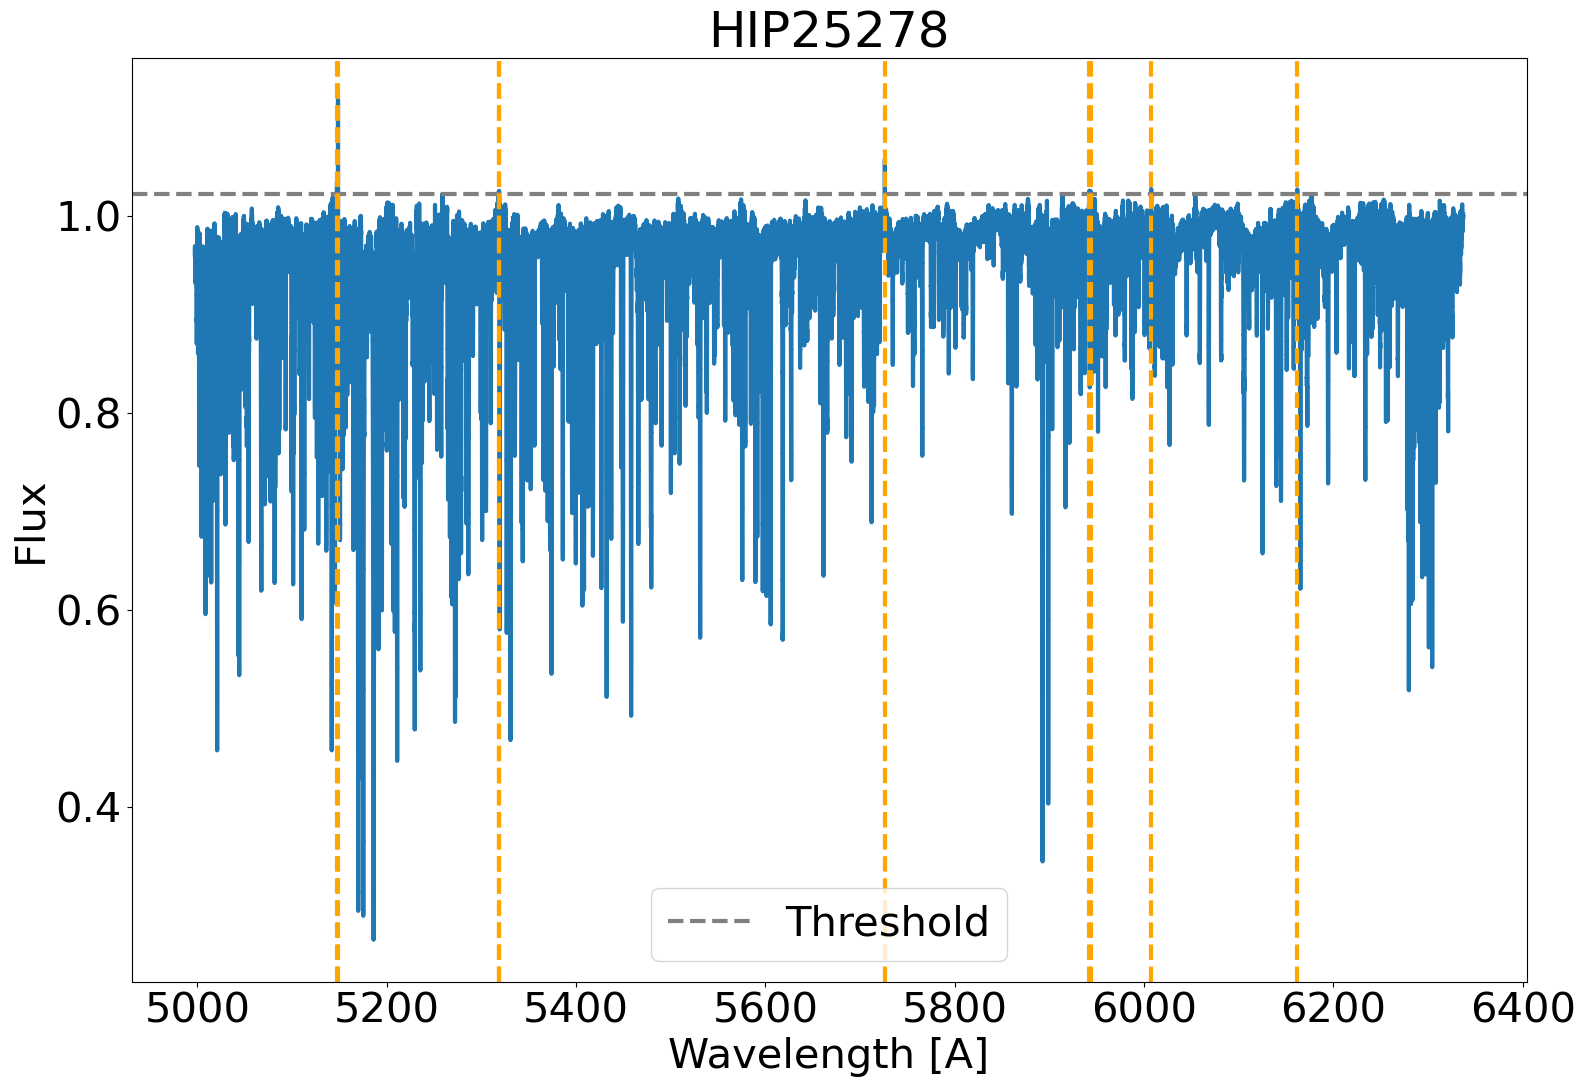

In [19]:
spect=flux
idxs1 = [] # indicies that are above continuum level
idxs2 = [] # indicies in idxs1 that are above the threshold value and are local maximas
idxs3 = [] # indicies in idxs2 that are gaussian-shaped
idxs4 = [] # indicies in idxs3 that are greater than 5 pixels in width

continuum = np.percentile(spect, 95)

for idx in np.arange(len(spect)):
    # first test: create an array of all indices that are above the continuum level
    if spect[idx] > continuum:
        idxs1 = idxs1 + [idx]

consecutive_indicies = []
i = 0
while i < (len(idxs1) - 1):
    list = [idxs1[i]]
    while i < len(idxs1) - 1 and idxs1[i + 1] == idxs1[i] + 1:
        list = np.append(list, idxs1[i+1])
        i += 1
    consecutive_indicies = consecutive_indicies + [list]
    i +=1

median_flux_vals = []
for idxs in consecutive_indicies:
    flux_vals = []
    for idx in idxs:
        flux_vals = np.append(flux_vals, spect[idx])
    median_flux = np.median(flux_vals)
    median_flux_vals = np.append(median_flux_vals, median_flux)

m = np.median(median_flux_vals)

print('m is: ' + str(m))

if SNR < 10:
    n = 1.13
elif SNR < 150:
    n = 1.05
else:
    n = 1.02

T = m * n

for idx in idxs1:
    if spect[idx] > T:
        idxs2 = idxs2 + [idx]

consecutive_indicies_idxs2 = []
i = 0
while i < (len(idxs2)):
    list = [idxs2[i]]
    while (i < len(idxs2) - 1) and (idxs2[i + 1] == idxs2[i] + 1):
        list = np.append(list, idxs2[i+1])
        i += 1
    consecutive_indicies_idxs2 = consecutive_indicies_idxs2 + [list]
    i +=1

median_indicies = []
for idxs in consecutive_indicies_idxs2:
    max_index = max(idxs, key=lambda i: spect[i])
    median_indicies = np.append(median_indicies, int(max_index))

idxs2 = np.array(median_indicies, dtype=int)

plt.step(wl, flux, lw=3)
plt.axhline(y=T, ls='--', lw=3, label='Threshold', color='gray')
for i in idxs2:
    plt.axvline(x=wl[i], ls='--', color='orange', lw=3)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title(star_name)
plt.legend()
plt.show()

In [20]:
# plt.step(wl, flux, lw=3)
# plt.plot(oversampled_x, gaus, lw=3, label = 'Gaussian Fit', color='olive')
# plt.axhline(y=T, ls='--', lw=3, label='Threshold', color='gray')
# for i in idxs2:
#     plt.axvline(x=wl[i], ls='--', color='orange', lw=3)
# plt.xlabel('Wavelength [A]')
# plt.xlim(5084.45, 5084.6)
# plt.ylim(0.8, 1.2)
# plt.ylabel('Flux')
# plt.title(star_name + ' Potential Laser Line Candidate')
# plt.legend()
# plt.show()

In [21]:
# plt.step(wl, flux, lw=3)
# # plt.step(oversampled_x, oversampled_y)
# # plt.scatter(wl[temp_left_bound], flux[temp_left_bound], s=300)
# # plt.scatter(wl[temp_right_bound], flux[temp_right_bound], s=300)
# # plt.axhline(y=T, ls='--', lw=3, label='Threshold', color='gray')
# # for i in idxs2:
# #     plt.axvline(x=wl[i], ls='--', color='orange', lw=3)
# plt.xlabel('Wavelength [A]')
# plt.xlim(5084.45, 5084.6)
# plt.ylim(0.8, 1.2)
# plt.ylabel('Flux')
# plt.title(star_name + ' Potential Laser Line Candidate')
# # plt.legend()

# for i in np.arange(5000, 6000):
#     plt.axvline(x=wl[i], lw=0.5, color='gray')
# plt.show()

In [22]:
# for idx in idxs2[0:1]:
#     # fit a gaussian to the peak, see if the width is greater than or equal to 2 pixels
#     # see how much signal resembles a gaussian
#     # if last test is commented out, ALSO check FWHM of gaussian

#     # DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
#     # PRO: can identify two signals together
#     # CON: can't deal with noise in signal

#     temp_ind = idx
#     left_bound = 0
#     while temp_ind > 1:
#         temp_ind -= 1
#         if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
#             left_bound = temp_ind
#             break
#     temp_ind = idx
#     right_bound = len(spect) - 1
#     while temp_ind < len(spect) - 4:
#         temp_ind += 1
#         if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
#             right_bound = temp_ind
#             break

#     x = wl[left_bound:right_bound + 2]
#     y = spect[left_bound:right_bound + 2]

#     # oversample detected signal to determine precise bounds on the edges of the signal
#     # use this to determine the FWHM of the signal in pixels
#     oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
#     spl = splrep(x, y, k=2)
#     oversampled_y = splev(oversampled_x, spl)

#     max_y = max(oversampled_y)
#     min_y = np.percentile(oversampled_y, 3) 
#     height = max_y - min_y
#     ind = oversampled_y.tolist().index(max_y)
#     pos = oversampled_x[ind]
#     min_width = 0.00001
#     max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
#     width_spacing = 0.001

#     chi_squared_values = []
#     width_vals = np.arange(min_width, max_width, width_spacing)
#     for w in width_vals:
#         gaus = gaussian(oversampled_x, height, pos, w, min_y)
#         chi_squared = chi(gaus, oversampled_y)
#         chi_squared_values = np.append(chi_squared_values, chi_squared)
#     min_chi_squared = min(chi_squared_values)
#     ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
#     width = width_vals[ind_of_min_chisquared]
#     gaus = gaussian(oversampled_x, height, pos, width, min_y)

#     width_threshold = False
#     gauss_threshold = False

#     # see if the signal fits a gaussian
#     if min_chi_squared < 11:
#         gauss_threshold = True
#         idxs3 = idxs3 + [idx]

#         # find the width of the gaussian in pixels

#         peak = max(gaus)
#         half_max = peak - height / 2

#         peak_index = gaus.tolist().index(peak)
#         temp_left_bound = peak_index
#         temp_right_bound = peak_index

#         while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
#             temp_left_bound -=1

#         while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
#             temp_right_bound += 1

#         pixel_width = (temp_right_bound - temp_left_bound) / 10

#         if pixel_width > 2.7:
#             width_threshold = True
#             idxs4 = idxs4 + [idx]



#     fig = plt.figure()
#     plt.step(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A', lw=3)
#     plt.plot(oversampled_x, gaus, lw=3, label = 'Gaussian')
#     if width_threshold == True:
#         # passed width threshold AND gaussian threshold
#         plt.title('PASS: chi-squared of ' + str(round(min_chi_squared, 4)) + ' and pixel width of ' + str(pixel_width))
#     elif gauss_threshold == True and width_threshold == False:
#         # failed width threshold
#         plt.title('PASS: chi-squared of ' + str(round(min_chi_squared, 4)))
# #         plt.title('FAIL: too narrow with pixel width of ' + str(pixel_width))
#     else:
#         # failed gaussian threshold
#         plt.title('FAIL: not gaussian-shaped: chi-squared of ' + str(round(min_chi_squared, 4)))

#     plt.xlabel('Wavelength [A]')
#     plt.ylabel('Flux')
#     for ind in np.arange(left_bound, right_bound):
#         plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
#     plt.legend()
#     plt.show()

## Results from Running the laser detection algorithm

In [23]:
results = pd.read_csv(file_location + '/' + str(spectrum_index) + '_' + star_name + '.csv')
# above_threshold = results['indicies'][0]
# above_threshold = above_threshold.strip('][').split(' ')
# while '' in above_threshold:
#     above_threshold.remove('')

gaussian_shaped = results['indicies'][1]
wider_than_PSF = results['indicies'][2]

gaussian_shaped = ast.literal_eval(gaussian_shaped)
wider_than_PSF = ast.literal_eval(wider_than_PSF)

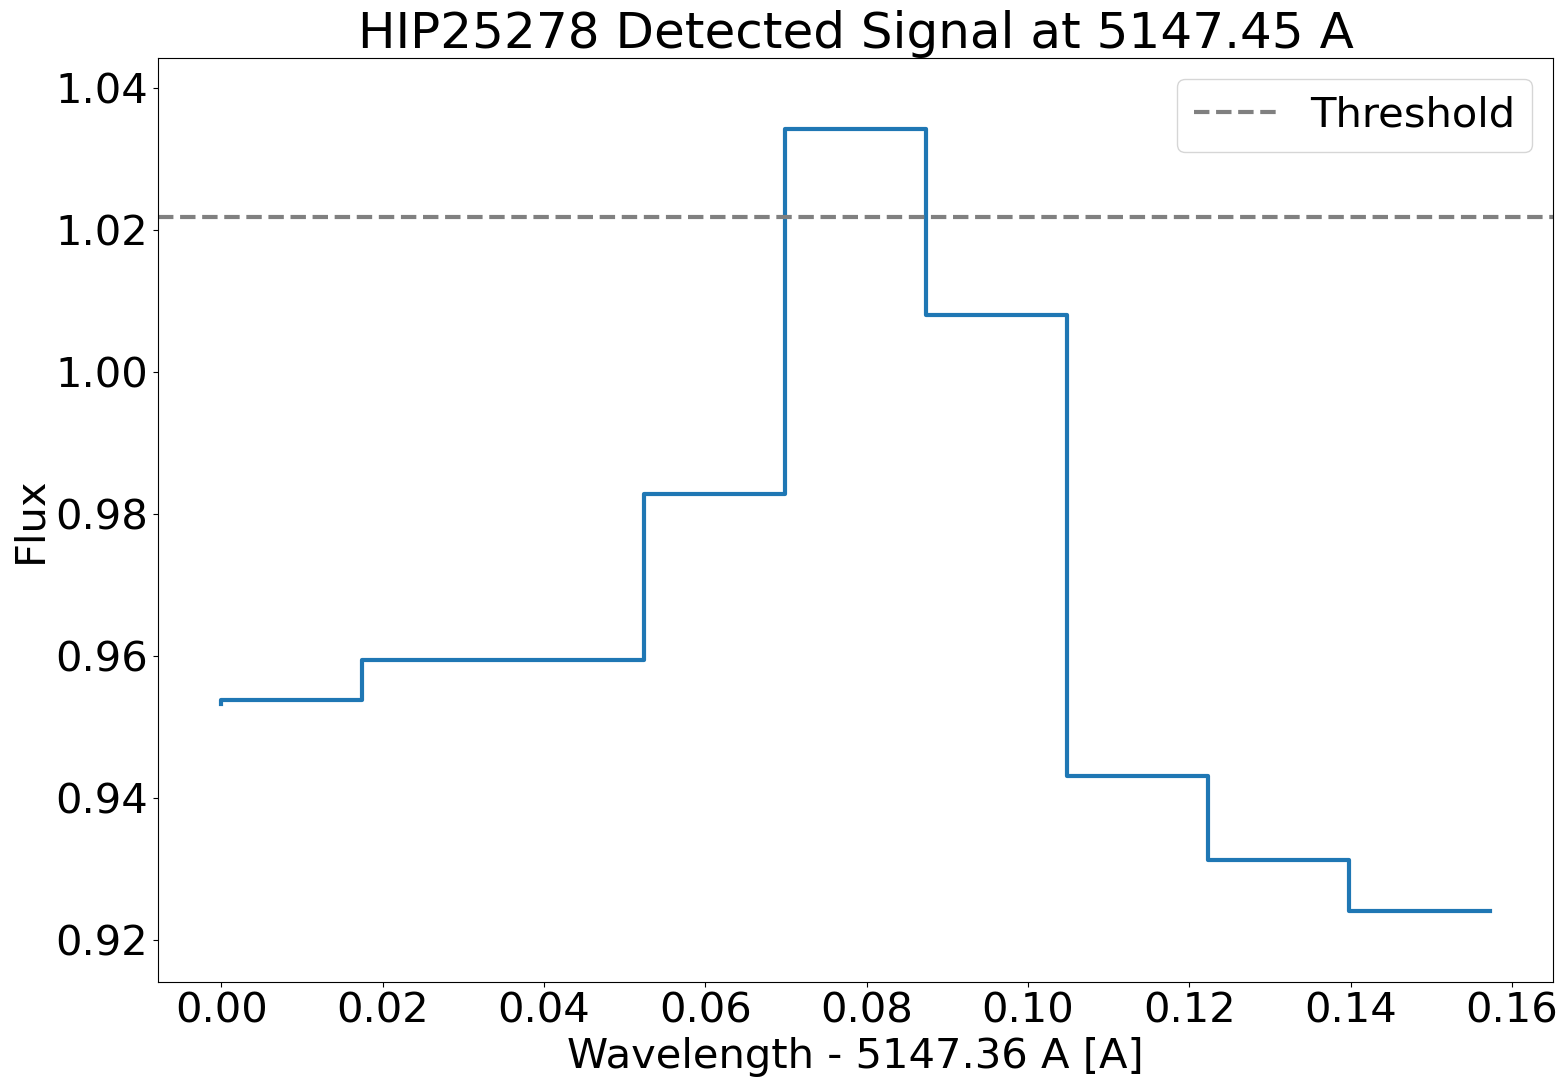

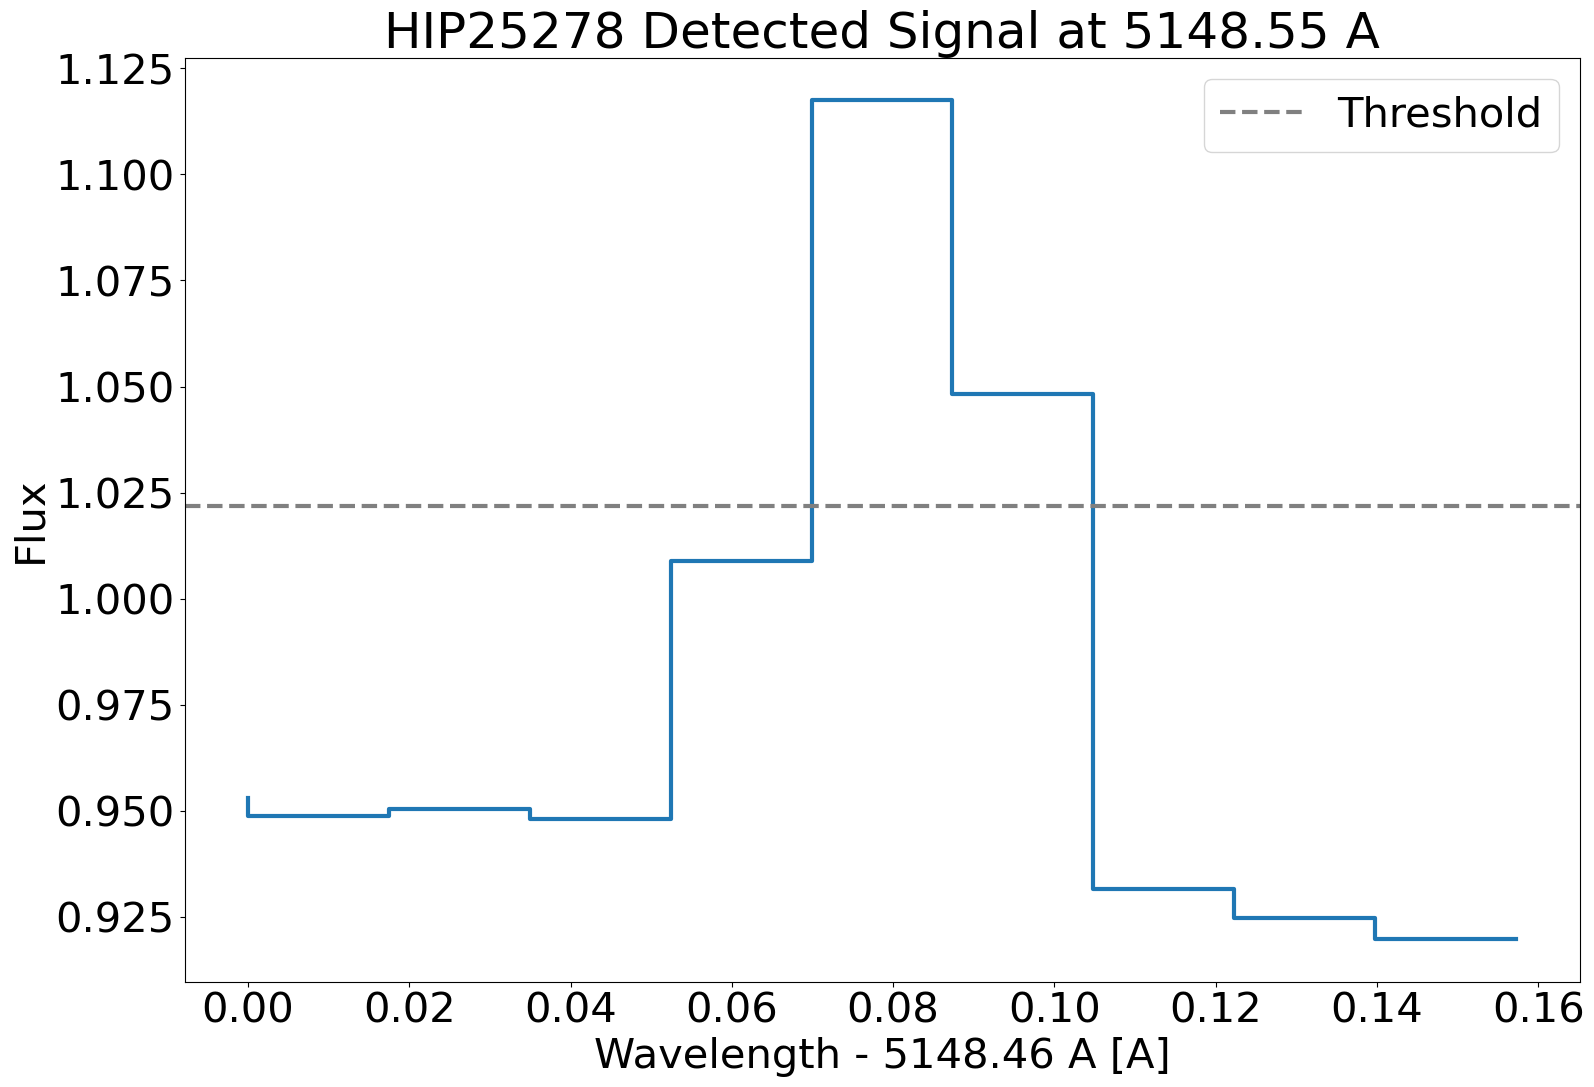

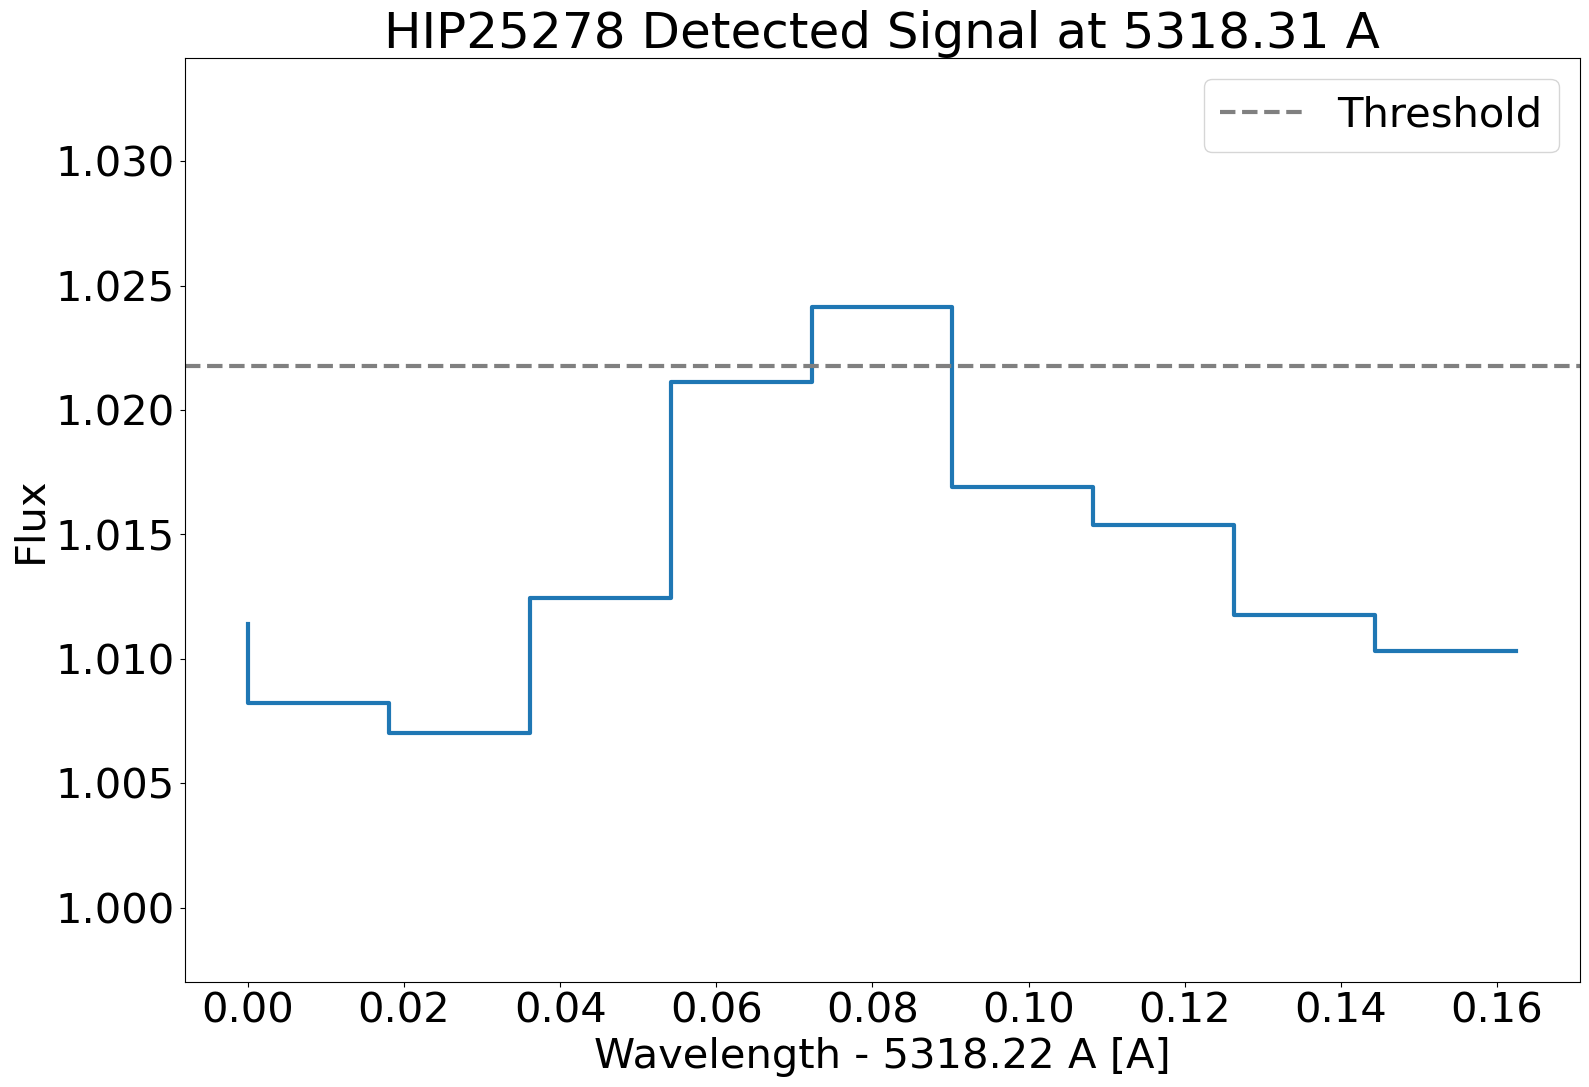

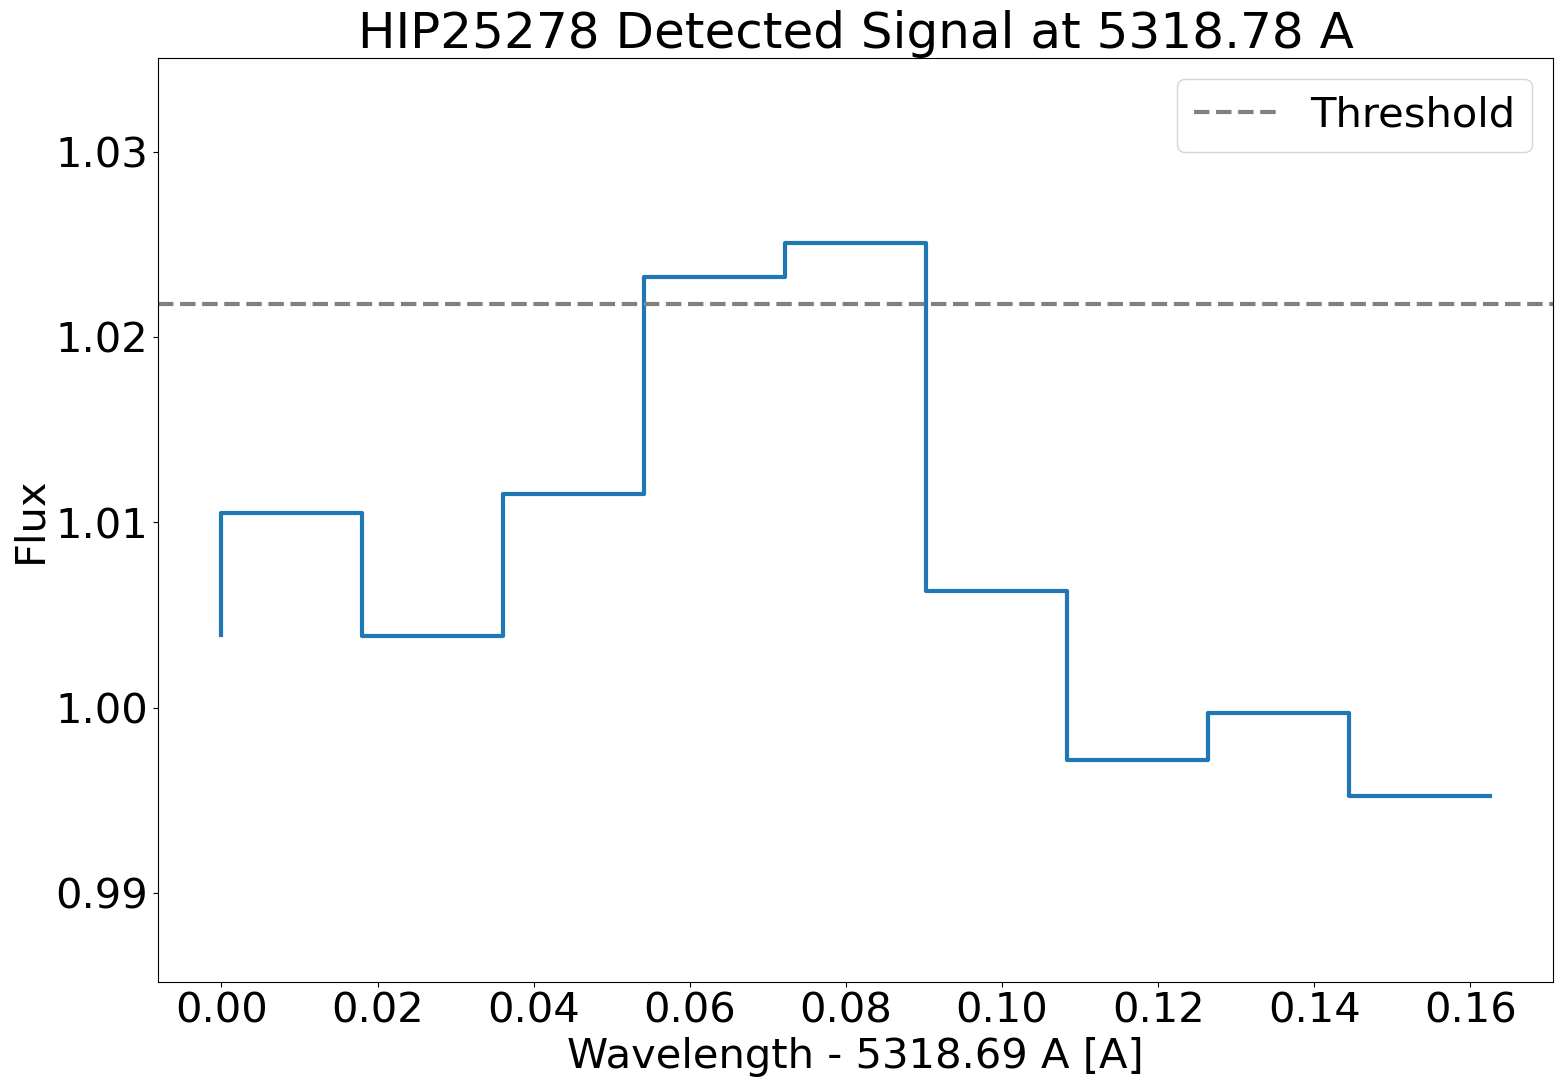

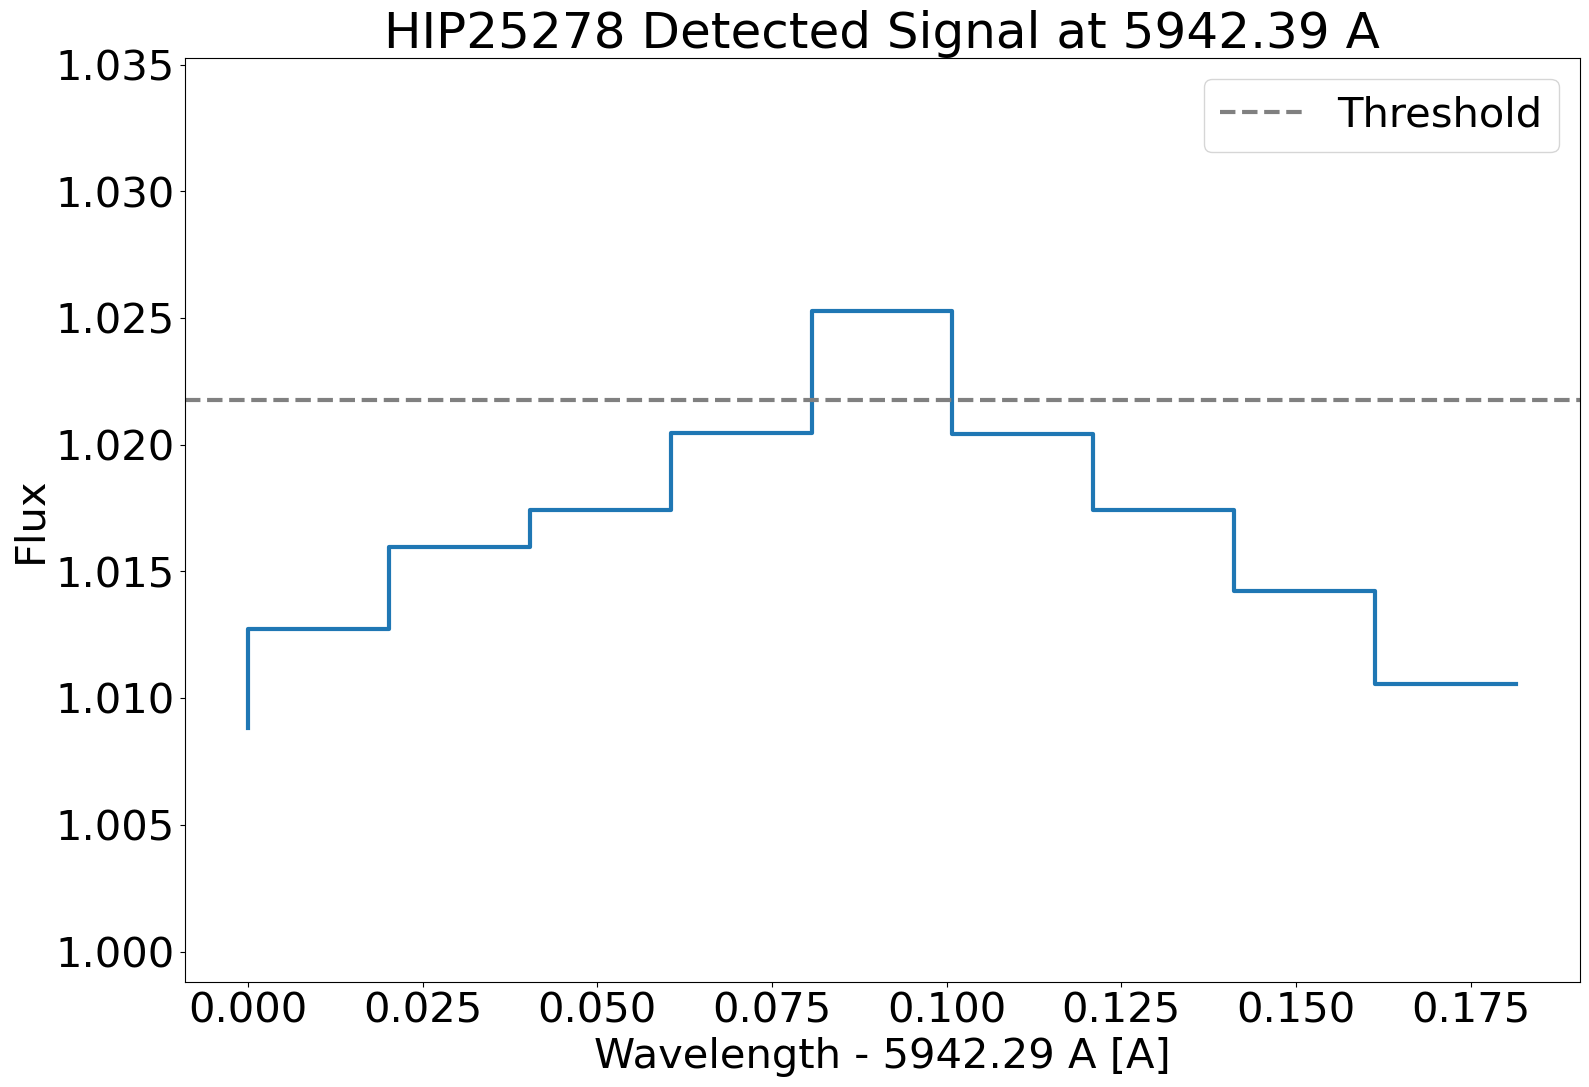

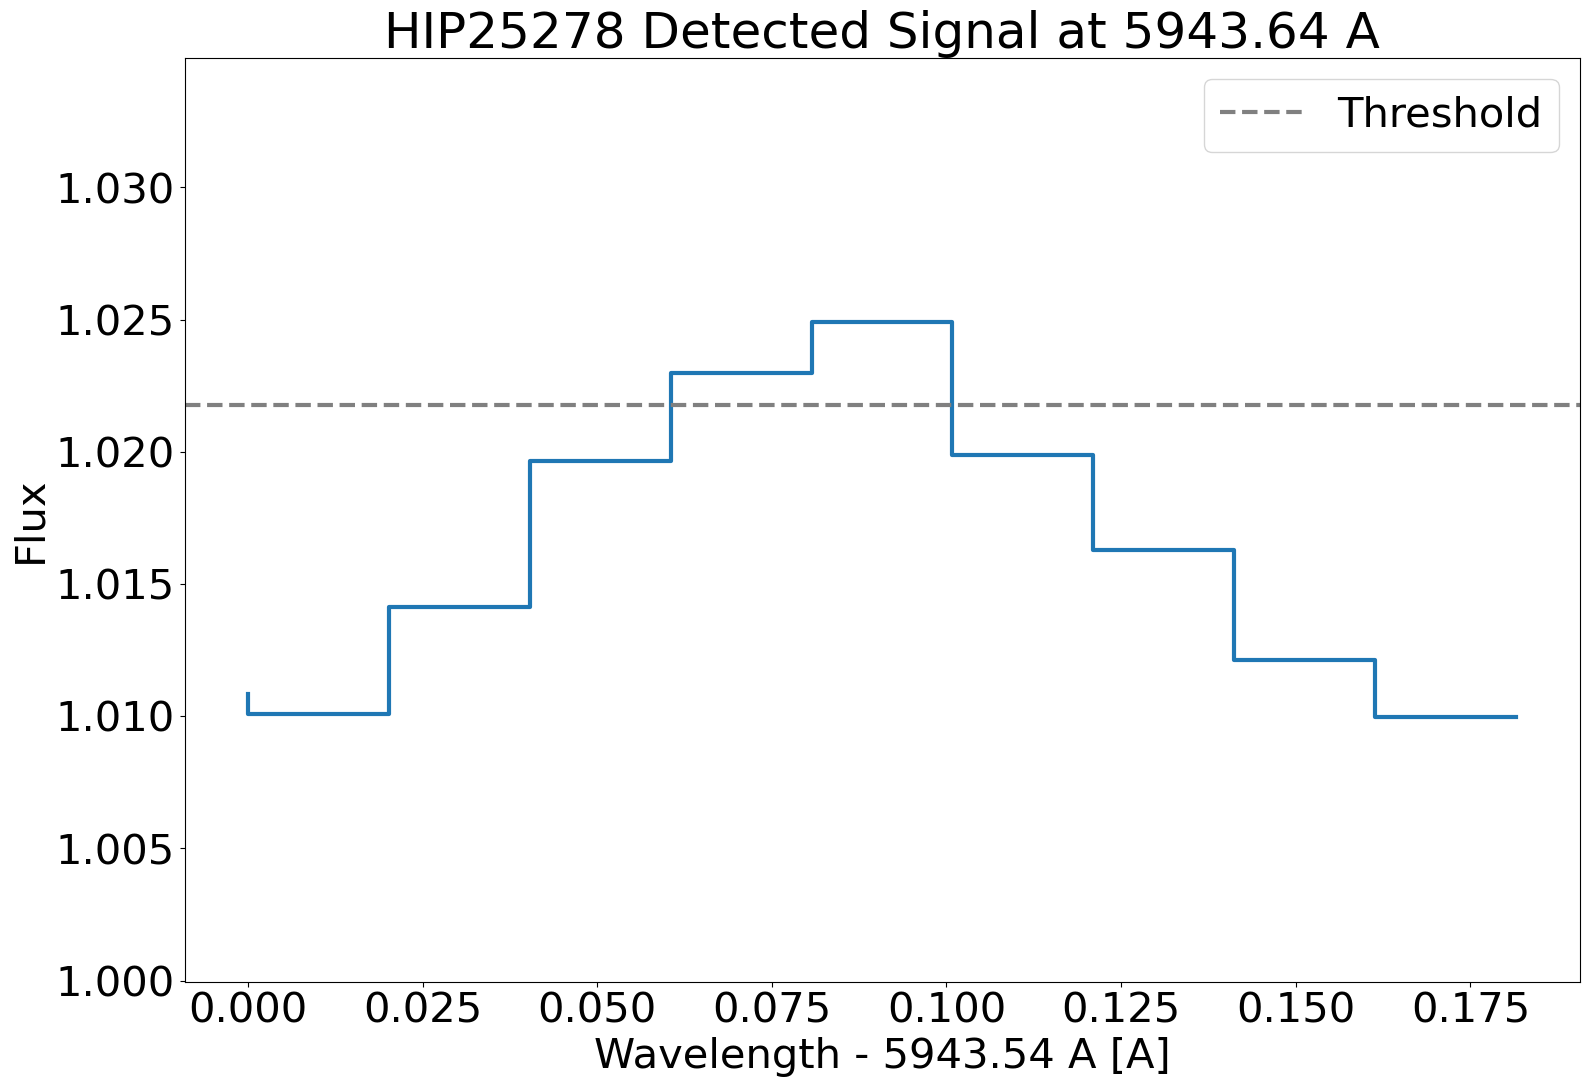

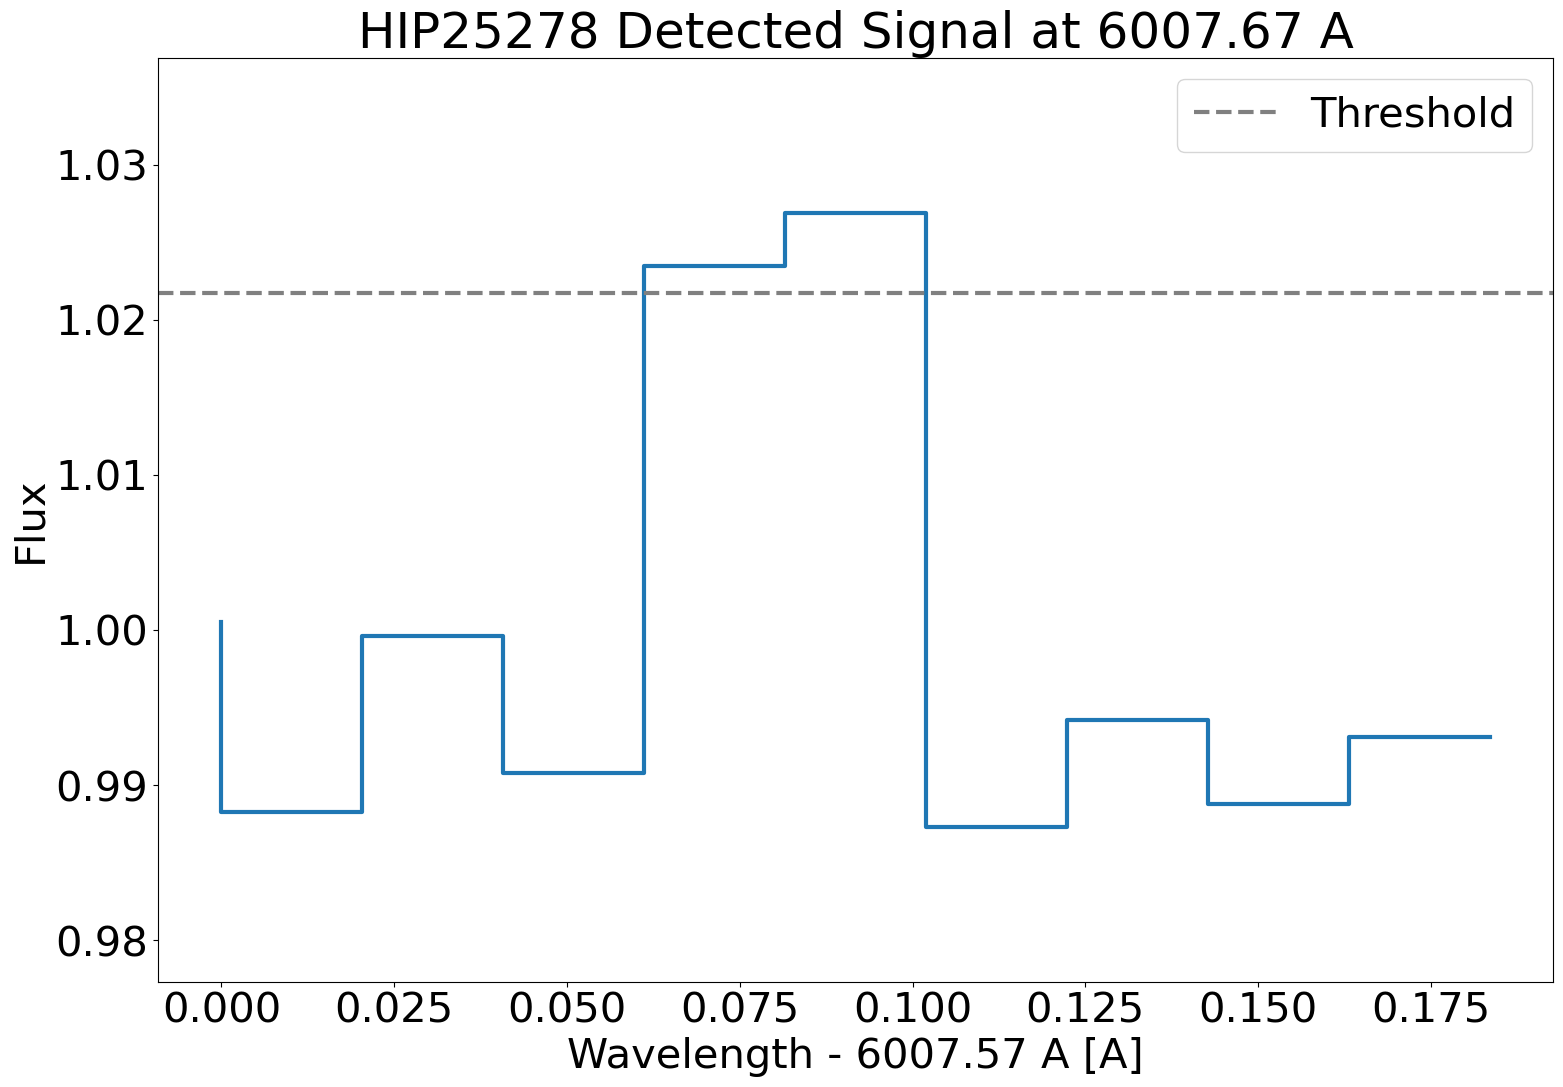

In [24]:
for i in wider_than_PSF:
    fig, ax = plt.subplots()
    ax.set_title(star_name + ' Detected Signal at ' + str(round(wl[i], 2)) + ' A')
    ax.set_xlabel('Wavelength - ' + str(round(wl[i-5], 2)) + ' A [A]')
    ax.set_ylabel('Flux')
    ax.step(wl[i-5:i+5] - wl[i-5], flux[i-5:i+5], lw=3)
    ax.axhline(y=T, ls = '--', color='gray', lw=3, label='Threshold')
    ax.set_ylim(min(flux[i-5:i+5]) - 0.01, max(flux[i-5:i+5]) + 0.01)
    ax.legend()
    plt.show()

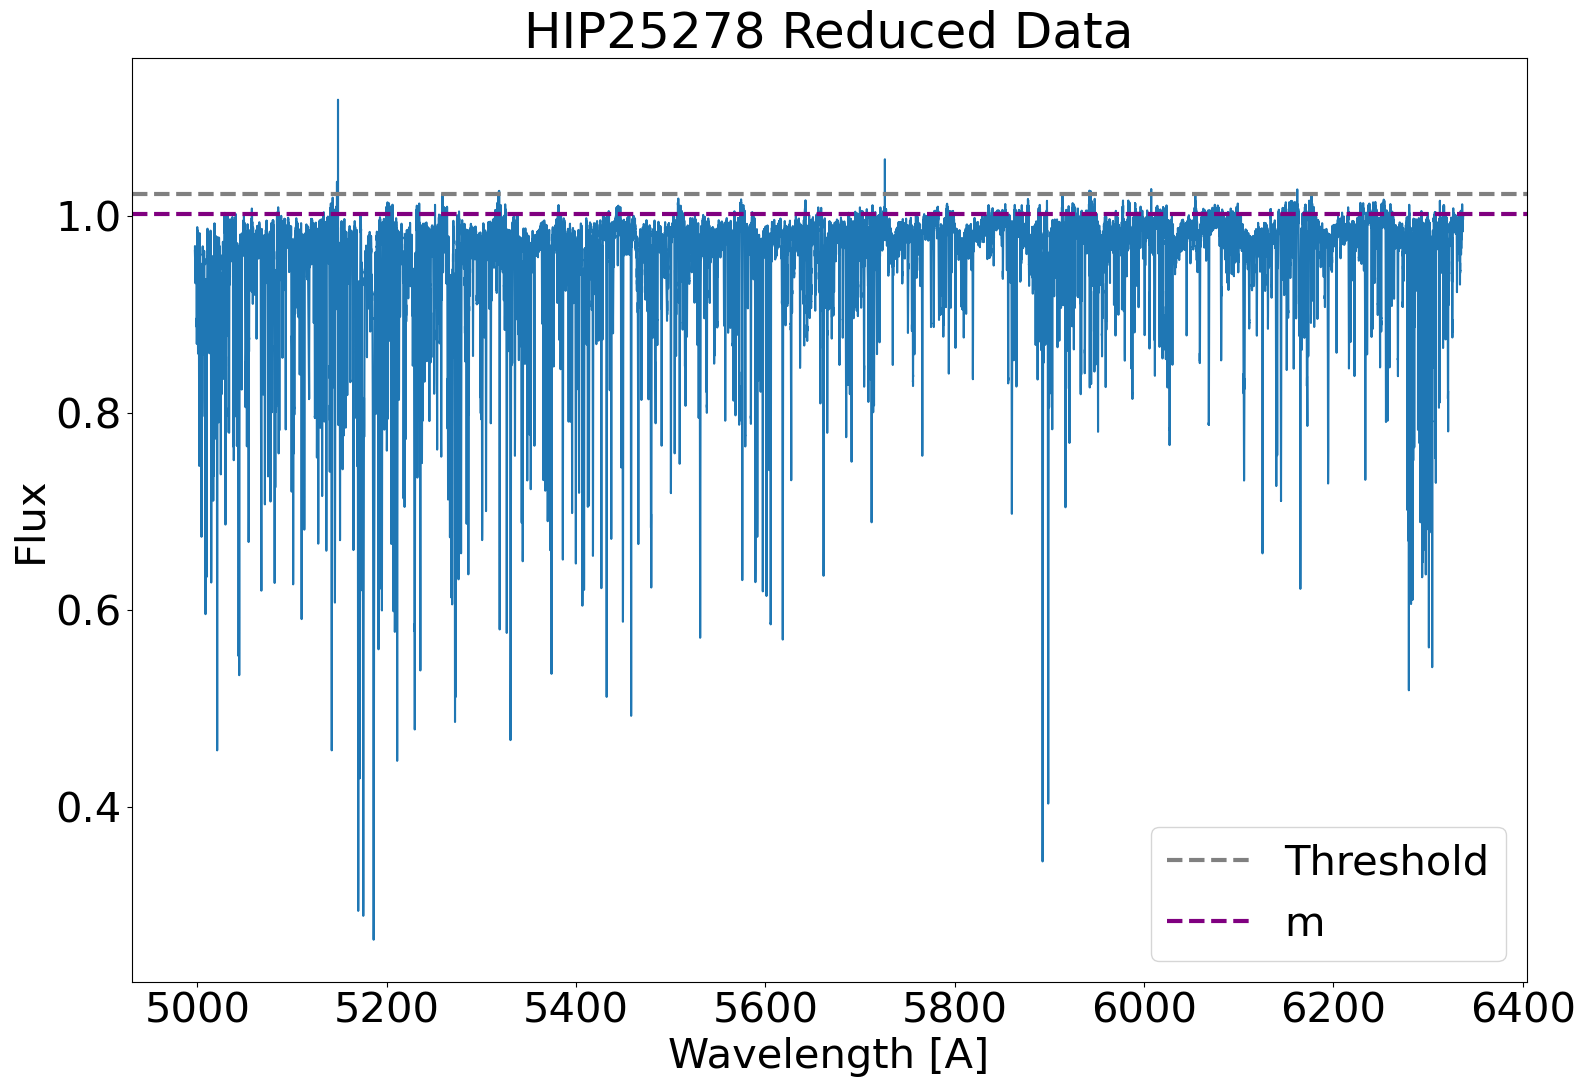

In [25]:
plt.plot(wl, flux)
plt.axhline(y=T, lw=3, ls='--', label='Threshold', color='gray')
plt.axhline(y=m, lw=3, ls='--', label='m', color='purple')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title(star_name + ' Reduced Data')
plt.legend()
plt.show()